In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from scipy.io import loadmat
import numpy as np
import operator

In [3]:
metadata = loadmat('data/imdb/imdb.mat')
metadata = metadata['imdb'][0, 0]

In [4]:
paths = metadata['full_path']
gender = metadata['gender']
is_single_person = np.isnan(metadata['second_face_score'])

In [5]:
# Unwrap objects
paths = np.array(list(map(operator.itemgetter(0), paths[0])))
gender = gender[0]
is_single_person = is_single_person[0]

In [6]:
paths = paths[is_single_person]
gender = gender[is_single_person]

In [7]:
idxs = paths.argsort()
paths = paths[idxs]
gender = gender[idxs]

In [8]:
is_nan_gender = ~np.isnan(gender)

In [9]:
paths = paths[is_nan_gender]
gender = gender[is_nan_gender]

00/nm0000100_rm1001569280_1955-1-6_2011.jpg


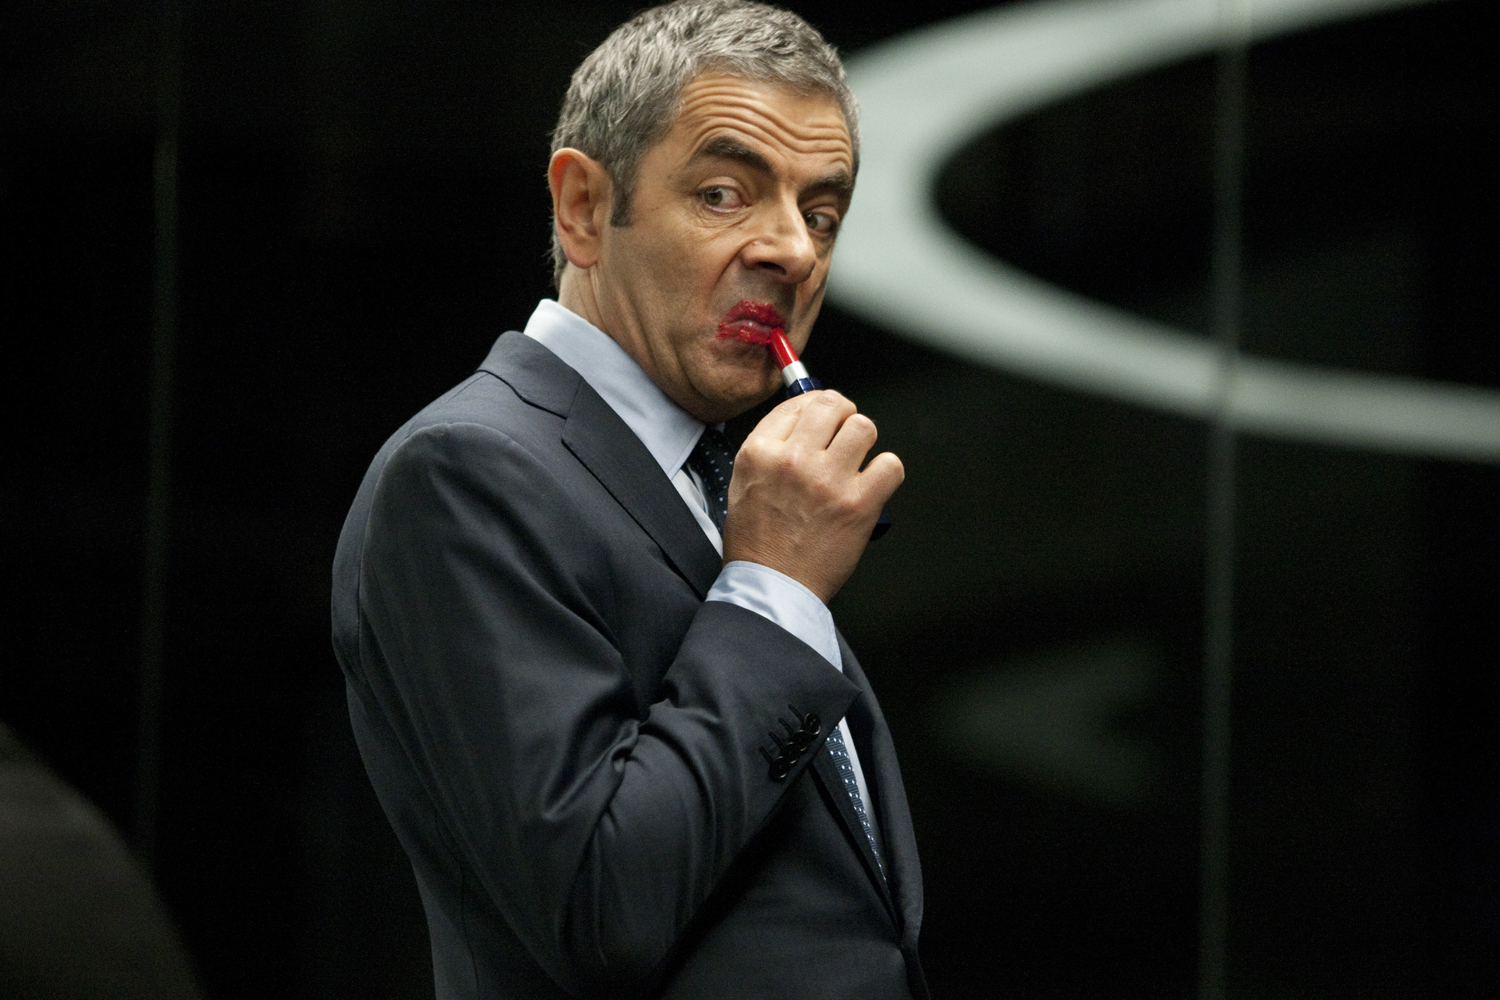

00/nm0000100_rm1002674432_1955-1-6_2003.jpg


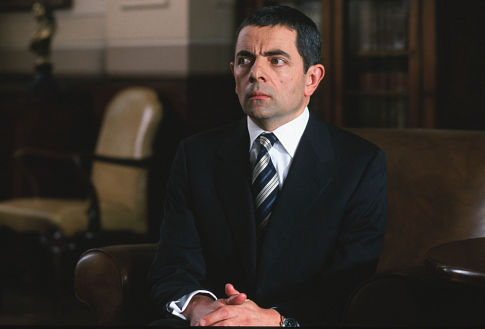

00/nm0000100_rm1018346496_1955-1-6_2011.jpg


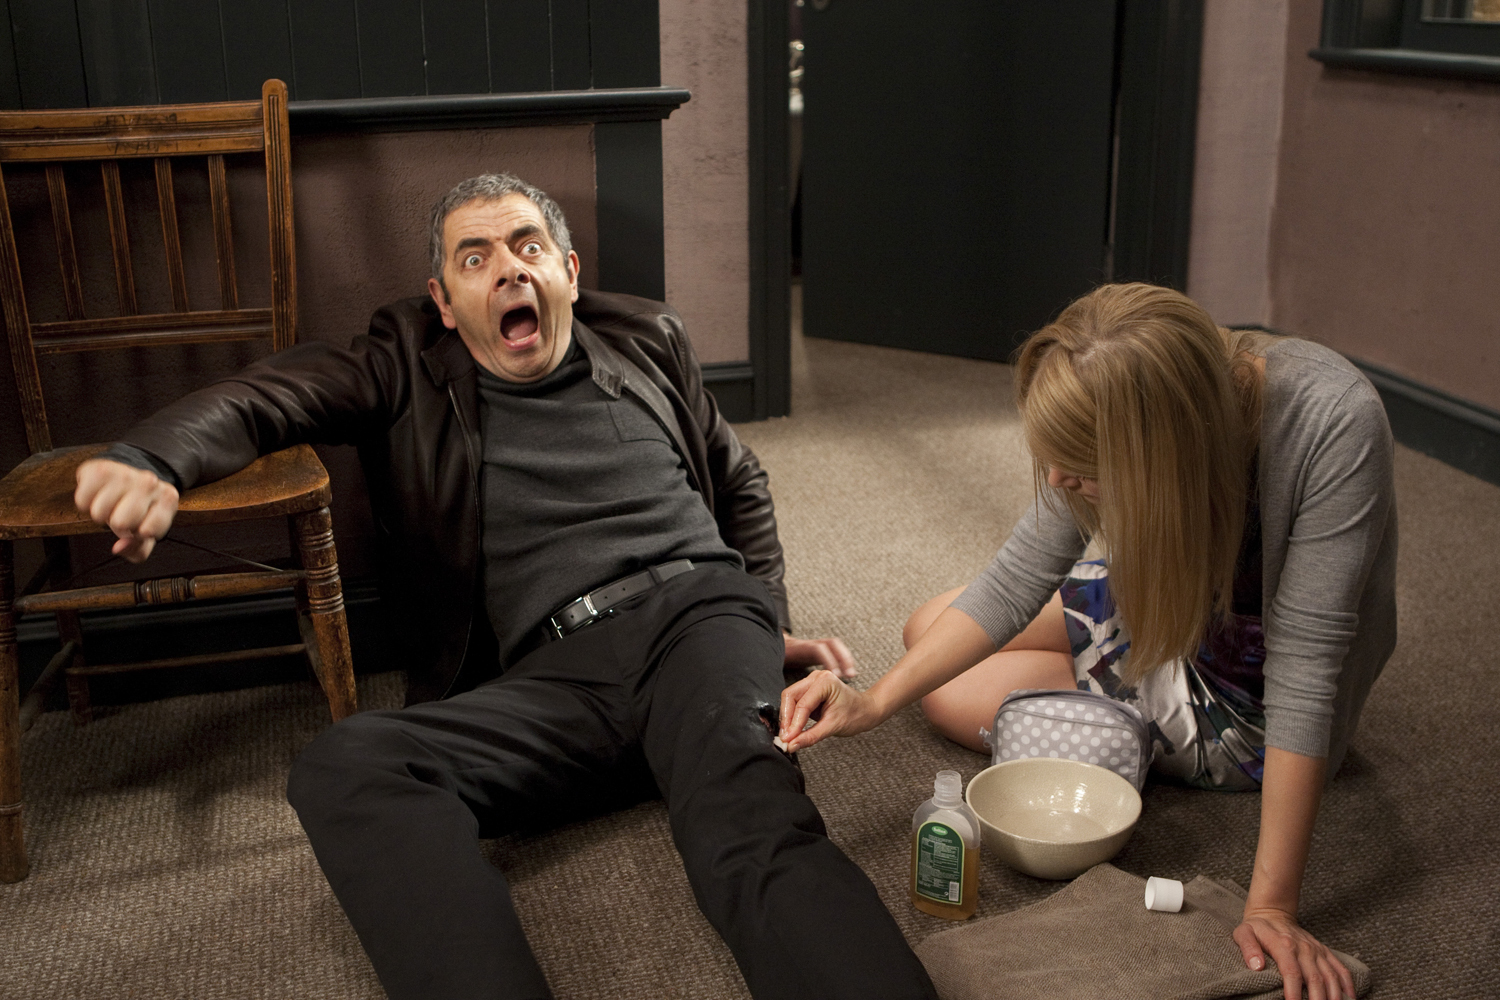

In [10]:
from IPython.display import Image, display

for path in paths[:3]:
    filepath = 'data/imdb/sample/train/' + path
    try:
        img = Image(filename=filepath, width=250, height=250)
    except:
        pass
    else:
        print(path)
        display(img)

In [11]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [12]:
paths_idxs = list(map(lambda s: s.startswith('00/nm0000100_') or s.startswith('07/nm0000107_'), paths))
paths = paths[paths_idxs]
gender = gender[paths_idxs]

In [13]:
PATH = 'data/imdb/sample/train/'

In [14]:
sz=256
arch=resnet34
o = 3
#data = ImageClassifierData.from_names_and_array(cls, path, fnames, y, classes, val_idxs=None, test_name=None,
#           num_workers=8, suffix='', tfms=(None,None), bs=64, continuous=False)
data = ImageClassifierData.from_names_and_array(PATH, paths, gender, np.array(['woman', 'man']),
                                                tfms=tfms_from_model(arch, sz), val_idxs=list(range(o)))

In [15]:
def get_augs(n):
    x, _ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[n]

data/imdb/sample/train/00/nm0000100_rm1001569280_1955-1-6_2011.jpg


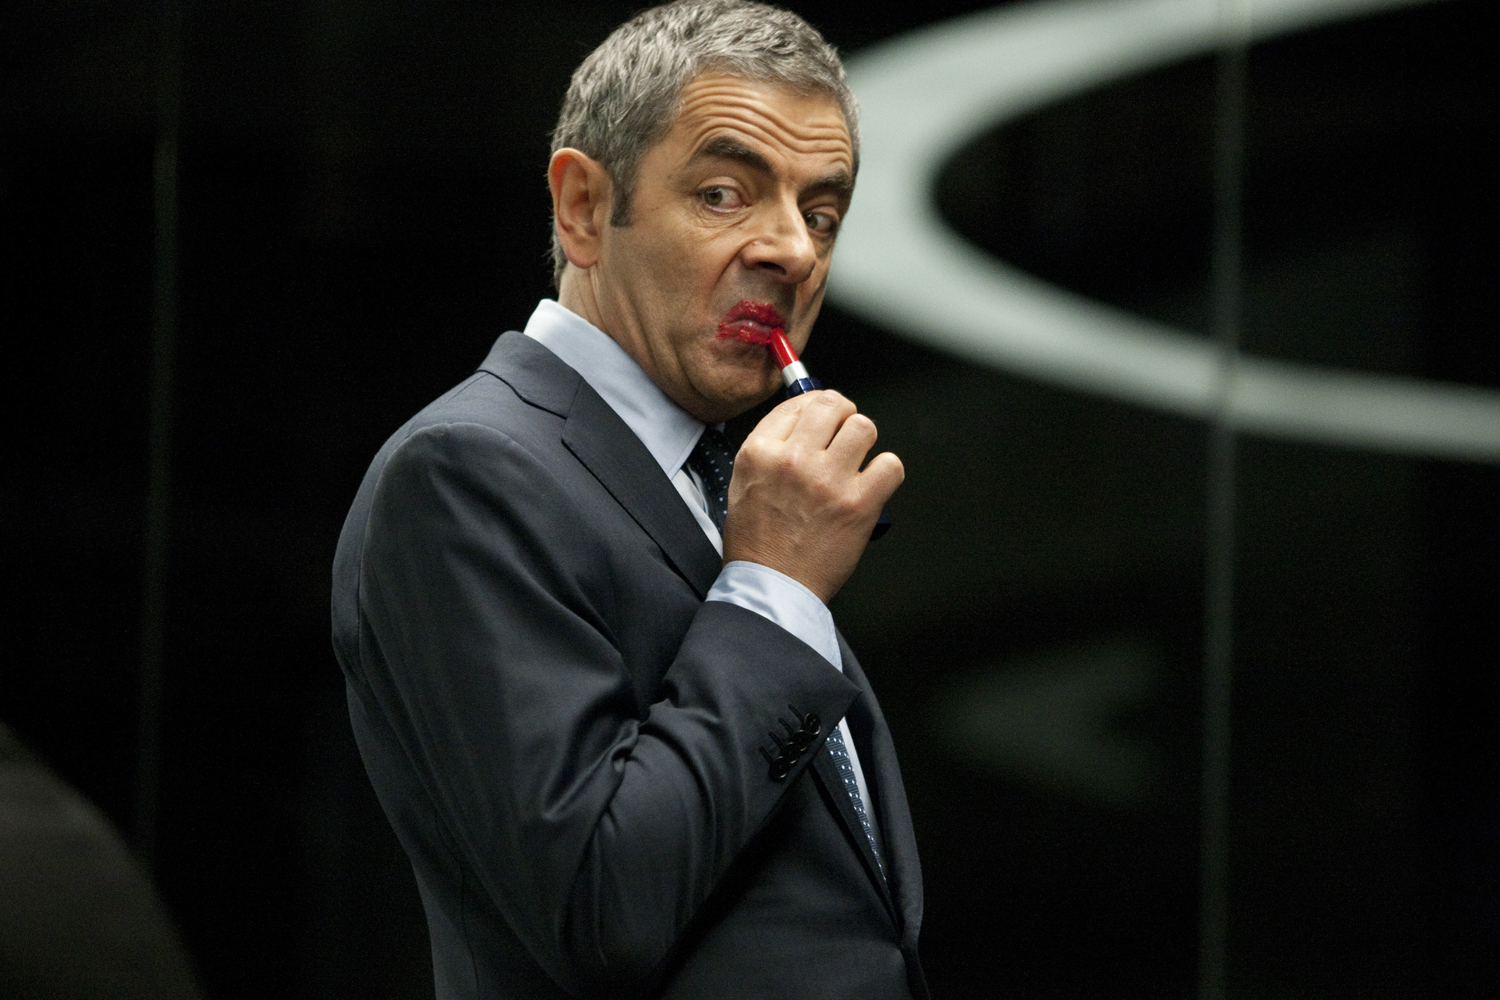

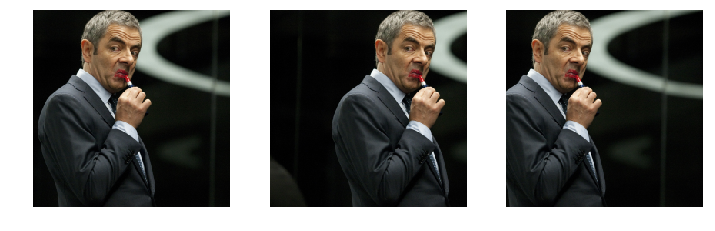

data/imdb/sample/train/00/nm0000100_rm1002674432_1955-1-6_2003.jpg


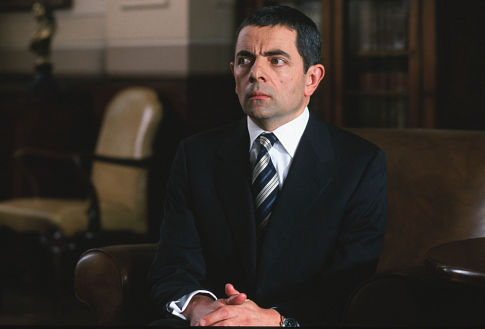

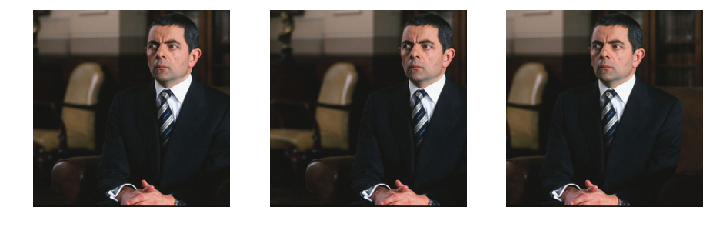

data/imdb/sample/train/00/nm0000100_rm1018346496_1955-1-6_2011.jpg


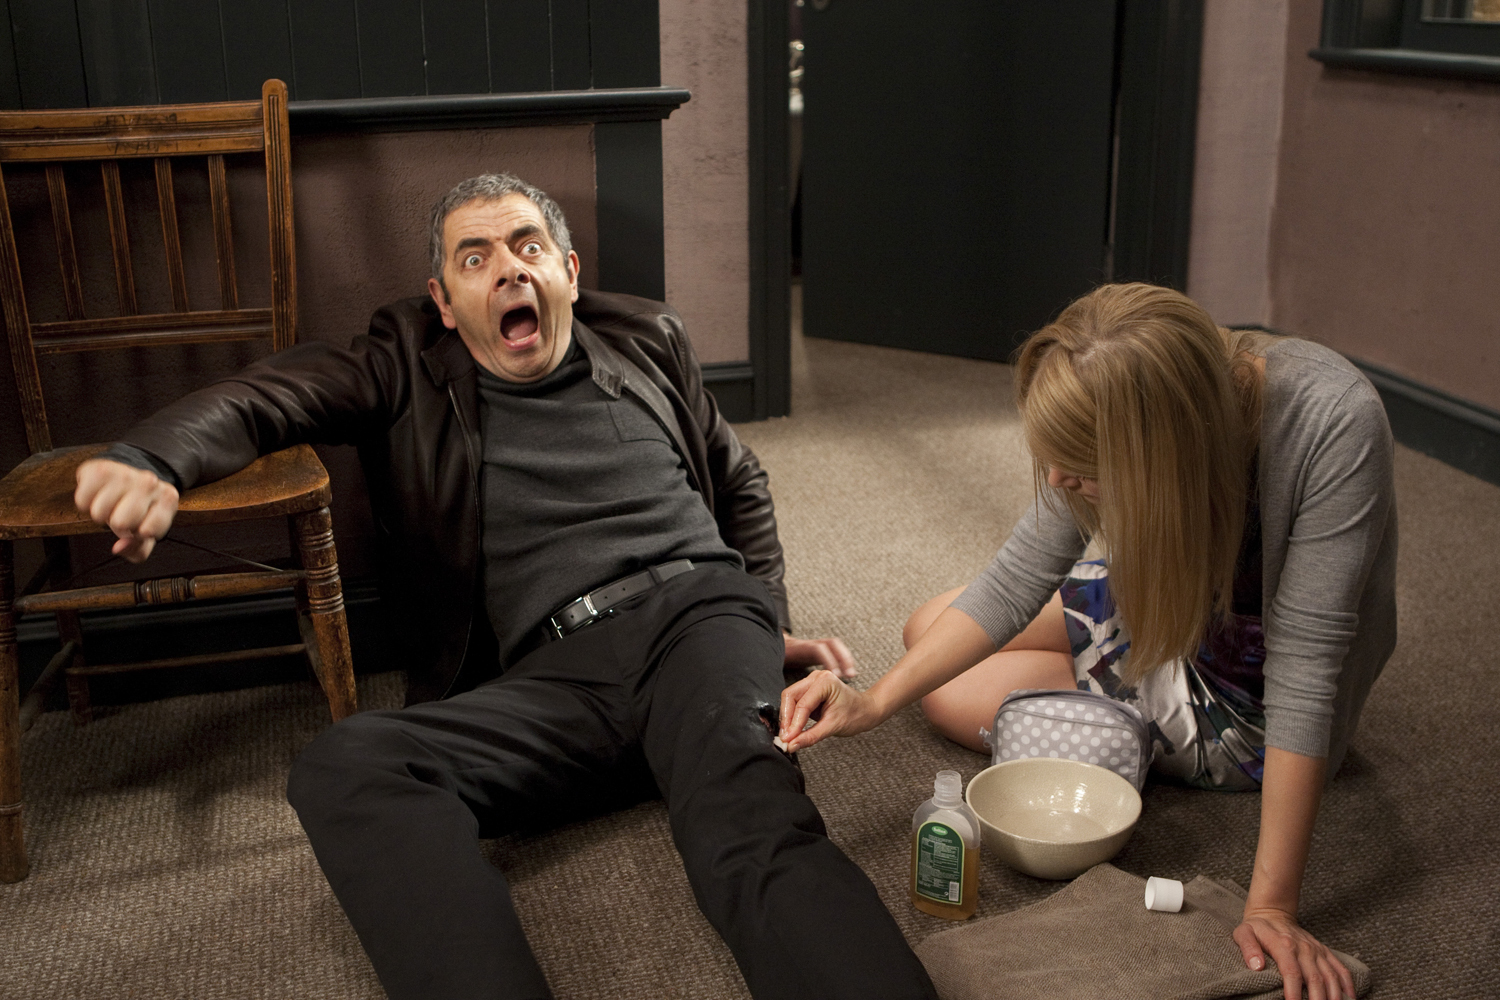

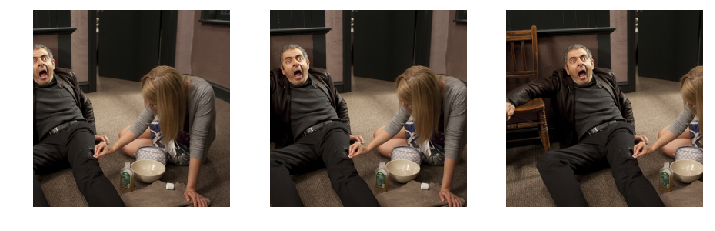

In [16]:
from IPython.display import Image, display
for j in range(o):
    p = PATH + paths[j]
    print(p)
    display(Image(filename=p, width=250, height=250))
    train_img1 = np.stack([get_augs(j) for i in range(3)])
    plots(train_img1, rows=1)
    plt.show()

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from scipy.io import loadmat
import numpy as np
import operator

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
metadata = loadmat('data/imdb/imdb.mat')
metadata = metadata['imdb'][0, 0]

paths = metadata['full_path']
gender = metadata['gender']
is_single_person = np.isnan(metadata['second_face_score'])

# Unwrap objects
paths = np.array(list(map(operator.itemgetter(0), paths[0])))
gender = gender[0]
is_single_person = is_single_person[0]

paths = paths[is_single_person]
gender = gender[is_single_person]

idxs = paths.argsort()
paths = paths[idxs]
gender = gender[idxs]

is_nan_gender = ~np.isnan(gender)

paths = paths[is_nan_gender]
gender = gender[is_nan_gender]

gender = np.array(list(map(int, gender)))

In [5]:
#PATH = 'data/imdb/sample/train/'
#is_train_path = lambda p: p[:13] == '00/nm0000100_'
#is_val_path = lambda p: p[:13] == '07/nm0000107_'

In [6]:
with open('data/imdb/whitelist_paths_06.txt') as f:
    val_whitelist_idxs = list(map(lambda s: s.strip(), f.readlines()))

with open('data/imdb/whitelist_paths_07.txt') as f:
    val_whitelist_idxs += list(map(lambda s: s.strip(), f.readlines()))

In [7]:
PATH = 'data/imdb/train/resized/'
is_train_path = lambda p: p[:3] in [f'0{i}/' for i in range(6)]
is_val_path = lambda p: p in val_whitelist_idxs

In [8]:
idxs = list(map(lambda p: is_train_path(p) or is_val_path(p), paths))
paths = paths[idxs]
gender = gender[idxs]


train_idxs = list(map(is_train_path, paths))
print(sum(train_idxs))

val_idxs = list(map(is_val_path, paths))
print(sum(val_idxs))

15519
2719


In [10]:
sz=224
bs=128
arch=resnet34
data = ImageClassifierData.from_names_and_array(PATH, paths, gender, np.array(['woman', 'man']),
                                                tfms=tfms_from_model(arch, sz), val_idxs=val_idxs, bs=bs)

In [11]:
learn = ConvLearner.pretrained(arch, data, pretrained=True)

In [12]:
learn.lr_find()

 90%|█████████ | 110/122 [01:30<00:06,  1.76it/s, loss=2.46]

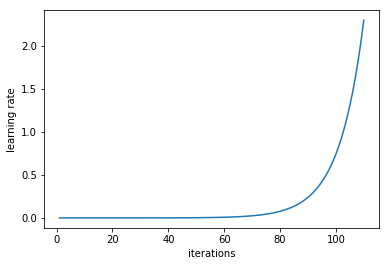

In [13]:
learn.sched.plot_lr()

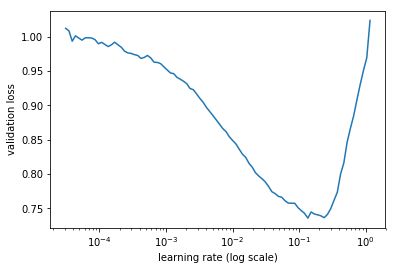

In [14]:
learn.sched.plot()

In [15]:
learn.fit(1.2e-2, 5)

epoch      trn_loss   val_loss   accuracy   
    0      0.512511   0.329166   0.862449  
    1      0.490008   0.313537   0.866863  
    2      0.473949   0.306189   0.866127  
    3      0.467281   0.305863   0.871644  
    4      0.462941   0.298443   0.873115  


[0.29844291432020464, 0.8731151155445145]

In [17]:
learn.save('imdb_1')

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from scipy.io import loadmat
import numpy as np
import operator

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
metadata = loadmat('data/imdb/imdb.mat')
metadata = metadata['imdb'][0, 0]

paths = metadata['full_path']
gender = metadata['gender']
is_single_person = np.isnan(metadata['second_face_score'])

# Unwrap objects
paths = np.array(list(map(operator.itemgetter(0), paths[0])))
gender = gender[0]
is_single_person = is_single_person[0]

paths = paths[is_single_person]
gender = gender[is_single_person]

idxs = paths.argsort()
paths = paths[idxs]
gender = gender[idxs]

is_nan_gender = ~np.isnan(gender)

paths = paths[is_nan_gender]
gender = gender[is_nan_gender]

gender = np.array(list(map(int, gender)))

In [5]:
with open('data/imdb/whitelist_paths_06.txt') as f:
    val_whitelist_idxs = list(map(lambda s: s.strip(), f.readlines()))

with open('data/imdb/whitelist_paths_07.txt') as f:
    val_whitelist_idxs += list(map(lambda s: s.strip(), f.readlines()))

In [6]:
PATH = 'data/imdb/train/resized/'
is_train_path = lambda p: p[:13] == '00/nm0000100_'
is_val_path = lambda p: p in val_whitelist_idxs

In [7]:
idxs = list(map(lambda p: is_train_path(p) or is_val_path(p), paths))
paths = paths[idxs]
gender = gender[idxs]


train_idxs = list(map(is_train_path, paths))
print(sum(train_idxs))

val_idxs = list(map(is_val_path, paths))
print(sum(val_idxs))

43
2719


In [8]:
sz=224
bs=128
arch=resnet34
data = ImageClassifierData.from_names_and_array(PATH, paths, gender, np.array(['woman', 'man']),
                                                tfms=tfms_from_model(arch, sz), val_idxs=val_idxs, bs=bs)

In [9]:
learn = ConvLearner.pretrained(arch, data, pretrained=True)

In [10]:
learn.load('imdb_1')

In [11]:
log_preds = learn.predict()

In [12]:
log_preds.shape

(2719, 2)

In [14]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(man)

In [17]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [18]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [49]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=2, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

In [50]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:10]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct women


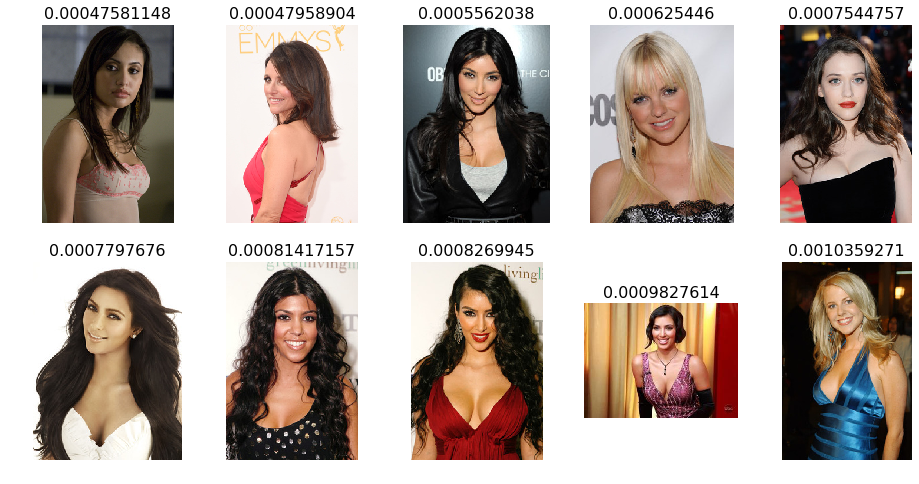

In [51]:
plot_val_with_title(most_by_correct(0, True), "Most correct women")

Most correct men


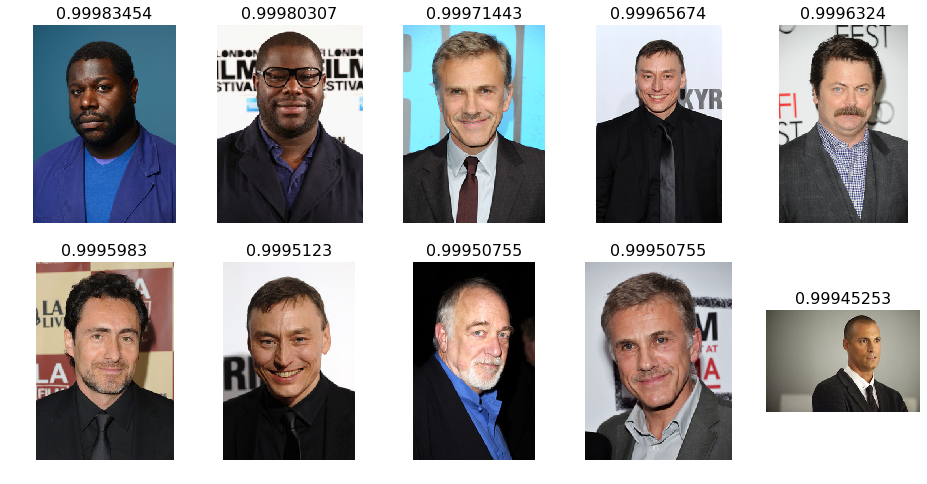

In [52]:
plot_val_with_title(most_by_correct(1, True), "Most correct men")

Most incorrect women


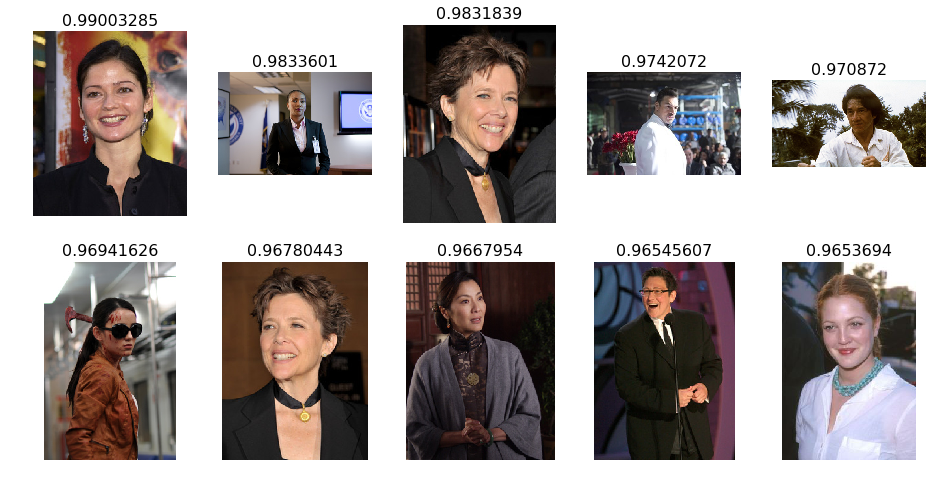

In [53]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect women")

Most incorrect men


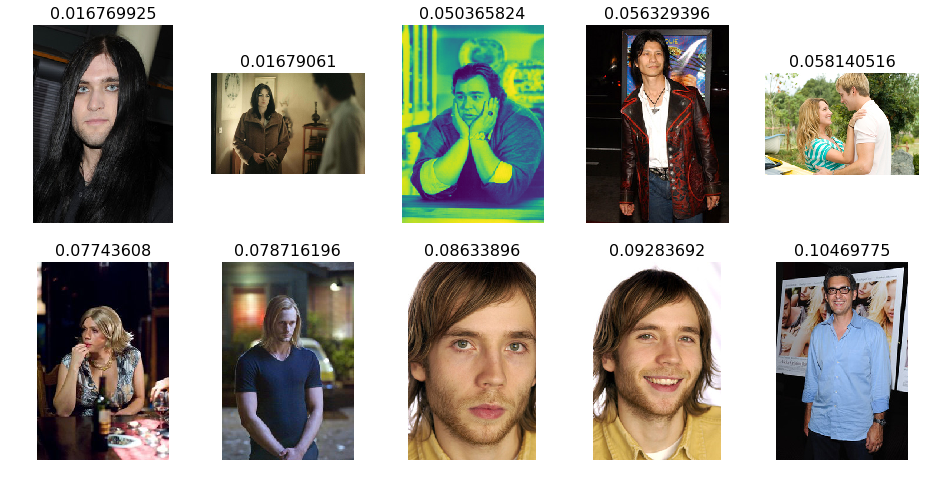

In [54]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect men")

Most uncertain predictions


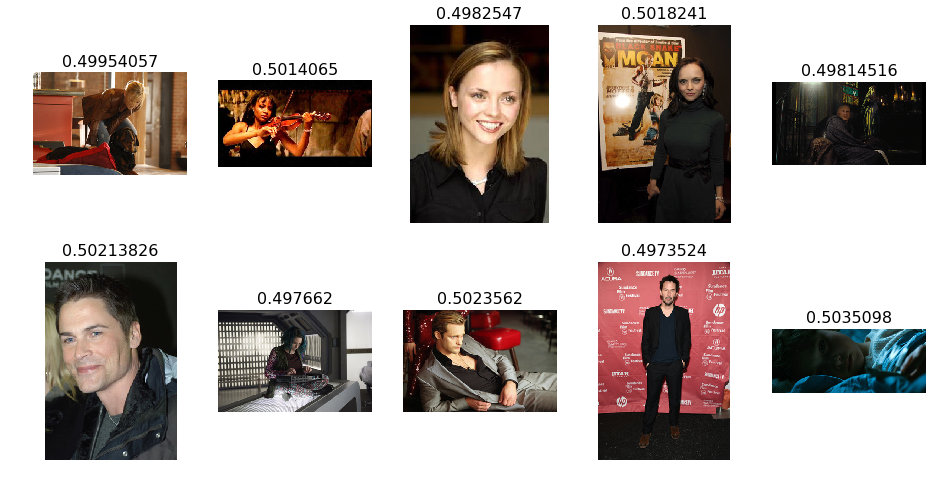

In [56]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:10]
plot_val_with_title(most_uncertain, "Most uncertain predictions")